In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2, 3"

import random
import copy
import time
import gc
import csv
import sys
import itertools
import more_itertools
import glob
import json
from datetime import datetime, timedelta, timezone

sys.path.append('..')
import result
import mymodel
import mode

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from Bio import SeqIO
from RNABERT.utils.bert import BertModel, get_config

JST = timezone(timedelta(hours=+9), 'JST')
dt_now = datetime.now(JST)
dt_now = dt_now.strftime('%Y%m%d-%H%M%S')
print(dt_now)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()

20220720-144019


2

In [2]:
len(seq_paths)

NameError: name 'seq_paths' is not defined

In [2]:
def kmer(seqs, k=1):
    #塩基文字列をk-mer文字列リストに変換
    kmer_seqs = []
    for seq in seqs:
        kmer_seq = []
        for i in range(len(seq)):
            if i <= len(seq)-k:
                kmer_seq.append(seq[i:i+k])
        kmer_seqs.append(kmer_seq)
    return kmer_seqs

def mask(seqs, rate = 0.2, mag = 1):
    # 与えられた文字列リストに対してmask。rateはmaskの割合,magは生成回数/1配列
    seq = []
    masked_seq = []
    label = []
    for i in range(mag):
        seqs2 = copy.deepcopy(seqs)
        for s in seqs2:
            label.append(copy.copy(s))
            mask_num = int(len(s)*rate)
            all_change_index = np.array(random.sample(range(len(s)), mask_num))
            mask_index, base_change_index = np.split(all_change_index, [int(all_change_index.size * 0.90)])
#             index = list(np.sort(random.sample(range(len(s)), mask_num)))
            for i in list(mask_index):
                s[i] = "MASK"
            for i in list(base_change_index):
                s[i] = random.sample(('A', 'U', 'G', 'C'), 1)[0] 
            masked_seq.append(s)
    return masked_seq, label

def convert(seqs, kmer_dict, max_length):
    # 文字列リストを数字に変換
    seq_num = [] 
    if not max_length:
        max_length = max([len(i) for i in seqs])
    for s in seqs:
        # NやWやYとかよくわからん塩基をMASKにしてしまおうと
        convered_seq = [kmer_dict[i] if i in kmer_dict.keys() else 1 for i in s] + [0]*(max_length - len(s))
        seq_num.append(convered_seq)
    return seq_num


In [3]:
class AccDataset(torch.utils.data.Dataset):
    def __init__(self, low_seq, accessibility):
        self.data_num = len(low_seq)
        self.low_seq = low_seq
        # self.seq_len = seq_len
        self.accessibility = accessibility
        
    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_low_seq = self.low_seq[idx]
        # out_seq_len = self.seq_len[idx]
        out_accessibility = self.accessibility[idx]

        return out_low_seq, out_accessibility

In [4]:
def make_dl(seq_data_path, acc_data_path):
    flag = False
    division = 1
    max_length = 440
    
    data_sets = seq_data_path
    seqs = []
    for i, data_set in enumerate(data_sets):
        for record in SeqIO.parse(data_set, "fasta"):
            record = record[::-1] #reverseします
            seq = str(record.seq).upper()
            seqs.append(seq)
    seqs_len = np.tile(np.array([len(i) for i in seqs]), 1)

    if max(seqs_len)>max_length:
        start = time.time()
        flag = True
        division += (max(seqs_len)-110) // 330
        max_length += division * 330
        finish = time.time()

    k = 1
    kmer_seqs = kmer(seqs, k)
    masked_seq, low_seq = mask(kmer_seqs, rate = 0.02, mag = 1)
    kmer_dict = {'MASK': 1, 'A': 2, 'U': 3, 'T': 3, 'G': 4, 'C': 5}
    low_seq = torch.tensor(np.array(convert(low_seq, kmer_dict, max_length)))

    if flag:
        splited_seq = []
        for i in low_seq:
            splited_seq.append(list(more_itertools.windowed(i ,440 ,step = 330)))
        low_seq = torch.tensor(splited_seq)
        num_seq, division, length = low_seq.shape
        low_seq = low_seq.view(-1, length)

    data_sets = acc_data_path
    accessibility = []
    for i, data_set in enumerate(data_sets):
        with open(data_set) as f:
            reader = csv.reader(f)
            for l in reader:
                pad_acc = l + ['-1']*(max_length - len(l))
                accessibility.append(pad_acc)
    accessibility = torch.tensor(np.array(accessibility, dtype=np.float32))

    if flag:
        start = time.time()
        splited_acc = []
        for i in accessibility:
            splited_acc.append(list(more_itertools.windowed(i ,440 ,step = 330)))
        accessibility = torch.tensor(splited_acc)
        accessibility = accessibility.view(-1, length)

        finish = time.time()

    ds_ACC = AccDataset(low_seq, accessibility)
    dl_ACC = torch.utils.data.DataLoader(ds_ACC, batch_size, num_workers=1, shuffle=False)

    return dl_ACC, flag, division

In [5]:
def model_device(device, model):
    print("device: ", device)
    model.to(device)
    model = torch.nn.DataParallel(model, device_ids=[0, 1]) # make parallel
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return model

# def objective(trained_para=torch.load('bertrna.pth')):
#     config.hidden_size = config.num_attention_heads * config.multiple
#     # config.adam_lr = 3e-4
#     # config.num_hidden_layers = 2
    
#     # model = BertModel(config)
#     # model = RBERT_CNN(model)
    
#     # model = CNN()
#     # model = DCNN()
#     model = TransCNN()
    
#     model = model_device(device, model)

#     # if args.pretraining:
#     #     model.load_state_dict(torch.load(args.pretraining))
#     model.load_state_dict(trained_para, strict=False)
        
#     # optimizer = optim.RAdam([{'params': model.parameters(), 'lr': config.adam_lr}])
#     optimizer = optim.AdamW([{'params': model.parameters(), 'lr': config.adam_lr}])
#     return model, optimizer, config

In [6]:
class RBERT(nn.Module):
    def __init__(self, net_bert):
        super(RBERT, self).__init__()
        self.bert = net_bert
        self.convs = nn.ModuleList()
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=3, padding=1, dilation=1))
        self.convs.append(mymodel.scSE(channels=120))
        for i in range(10):
            self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=7, padding=3*5, dilation=5))
        self.convs.append(mymodel.scSE(channels=120))
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=480, kernel_size=1))
        self.convs.append(mymodel.conv1DBatchNorm(in_channels=480, out_channels=1, kernel_size=9, padding=4))
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, attention_show_flg=False):
        encoded_layers, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_flg=False)
        x = encoded_layers
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)
        return x.view(x.shape[0], -1)

class NBERT(nn.Module):
    def __init__(self, net_bert):
        super(NBERT, self).__init__()
        self.bert = net_bert
        self.convs = nn.ModuleList()
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=3, padding=1, dilation=1))
        self.convs.append(mymodel.scSE(channels=120))
        for i in range(10):
            self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=7, padding=3*5, dilation=5))
        self.convs.append(mymodel.scSE(channels=120))
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=480, kernel_size=1))
        self.convs.append(mymodel.conv1DBatchNorm(in_channels=480, out_channels=1, kernel_size=9, padding=4))
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, attention_show_flg=False):
        encoded_layers, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_flg=False)
        x = encoded_layers
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)
        return x.view(x.shape[0], -1)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(6, 120)        
        self.convs = nn.ModuleList()
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=3, padding=1, dilation=1))
        self.convs.append(mymodel.scSE(channels=120))
        for i in range(10):
            self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=7, padding=3*5, dilation=5))
        self.convs.append(mymodel.scSE(channels=120))
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=480, kernel_size=1))
        self.convs.append(mymodel.conv1DBatchNorm(in_channels=480, out_channels=1, kernel_size=9, padding=4))        
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)        
        return x.view(x.shape[0], -1)

class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()
        self.embedding = nn.Embedding(6, 120)        
        self.convs = nn.ModuleList()
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=3, padding=1, dilation=1))
        self.convs.append(mymodel.scSE(channels=120))
        for i in range(50):
            self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=120, kernel_size=7, padding=3*5, dilation=5))
        self.convs.append(mymodel.scSE(channels=120))
        self.convs.append(mymodel.conv1DBatchNormRelu(in_channels=120, out_channels=480, kernel_size=1))
        self.convs.append(mymodel.conv1DBatchNorm(in_channels=480, out_channels=1, kernel_size=9, padding=4))        
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)        
        return x.view(x.shape[0], -1)


In [9]:
class BertForAcc(nn.Module):
    def __init__(self, net_bert):
        super(BertForAcc, self).__init__()
        self.bert = net_bert
        self.convs = nn.ModuleList()
        self.convs.append(model.conv1DBatchNormMish(in_channels=120, out_channels=120,
                                                    kernel_size=3, padding=1, dilation=1))
        self.convs.append(model.scSE(channels=120))
        for i in range(5):
            self.convs.append(model.conv1DBatchNormRelu(in_channels=120, out_channels=120,
                                                    kernel_size=7, padding=3*9, dilation=9))
            self.convs.append(model.scSE(channels=120))
            self.convs.append(model.conv1DBatchNormRelu(in_channels=120, out_channels=120,
                                                    kernel_size=7, padding=3*5, dilation=5))
            self.convs.append(model.conv1DBatchNormRelu(in_channels=120, out_channels=120,
                                                    kernel_size=7, padding=3*1, dilation=1))
            self.convs.append(model.scSE(channels=120))
        
        self.convs.append(model.conv1DBatchNormMish(in_channels=120, out_channels=480, kernel_size=1))
        self.convs.append(model.conv1DBatchNorm(in_channels=480, out_channels=1, kernel_size=9, padding=4))
        

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, attention_show_flg=False):
        if attention_show_flg == False:
            encoded_layers, pooled_output = self.bert(
                input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_flg=False)
        else:
            encoded_layers, pooled_output, attention_probs = self.bert(
                input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False, attention_show_flg=True)

        x = encoded_layers
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)
        
        x = x.view(x.shape[0], -1)

        return x




In [59]:
# params_update = []
# for name, param in model.named_parameters():
# #     if 'embeddings' in name:
# #         param.requires_grad = False
# #     elif 'encoder.layer.0' in name:
# #         param.requires_grad = False
# #     elif 'encoder.layer.1' in name:
# #         param.requires_grad = False
# #     elif 'encoder.layer.2' in name:
# #         param.requires_grad = False
# #     else:
#     param.requires_grad = True
#     params_update.append(name)


In [60]:
# comment = 'trans2layer_allparamupdate_100CNN_1m'

max_length ,batch_size = 440, 128
seq_path = '../../data/rbert/structure/sequence/'
acc_path = '../../data/rbert/structure/accessibility/'

train_seq_paths = []
train_acc_paths = []
for n in range(2):
    train_seq_paths.append([f'{seq_path}seq{n*10+i+1}.fa' for i in range(2)])
    train_acc_paths.append([f'{acc_path}acc{n*10+i+1}.csv' for i in range(2)])

val_seq_path = [f'{seq_path}seq{i+1}.fa' for i in range(999,1000)]
val_acc_path = [f'{acc_path}acc{i+1}.csv' for i in range(999,1000)]


criterion = nn.MSELoss().to(device)
config = get_config(file_path = "./RNA_bert_config.json")
model, optimizer, config = objective()
epochs = 10

device:  cuda


In [61]:
model.to(device)
torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()

train_loss_list = []
val_loss_list = []
train_time_list = []
val_time_list = []
data_all = []
target_all = []
output_all = []
val_dl_ACC, flag, division = make_dl(val_seq_path, val_acc_path)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    for phase in ['train', 'val']:
        start = time.time()
    
        if (epoch==0) and (phase=='train'):
            continue
        
        if phase == 'train':
            model.train()
            avg_losses = []
            for train_seq_path, train_acc_path in zip(train_seq_paths, train_acc_paths):
                train_dl_ACC, _, _ = make_dl(train_seq_path, train_acc_path)
                epoch_loss = 0
                for batch in train_dl_ACC:
                    low_seq, accessibility = batch
                    data = low_seq.to(device, non_blocking=False)
                    target = accessibility.to(device, non_blocking=False)
                    optimizer.zero_grad()
                    if data.size()[0] == 1:
                        continue
                    with torch.cuda.amp.autocast():
                        with torch.set_grad_enabled(phase=='train'):
                            output = model(data)
                            loss = criterion(output, target)                            
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                            epoch_loss += loss.item() * data.size(0)
                            
                avg_losses.append(epoch_loss / len(train_dl_ACC.dataset))
            avg_loss = sum(avg_losses) / len(avg_losses)

        else:
            model.eval()            
            epoch_loss = 0
            for batch in val_dl_ACC:
                low_seq, accessibility = batch
                data = low_seq.to(device, non_blocking=False)
                target = accessibility.to(device, non_blocking=False)

                optimizer.zero_grad()
                if data.size()[0] == 1:
                    continue
                with torch.cuda.amp.autocast():
                    output = model(data)
                    if (epoch+1)==epochs:
                        data_all.append(data.cpu().detach().numpy())
                        target_all.append(target.cpu().detach().numpy())
                        output_all.append(output.cpu().detach().numpy())
                    
                    loss = criterion(output, target)
                    epoch_loss += loss.item() * data.size(0)         
            avg_loss = epoch_loss / len(val_dl_ACC.dataset)
        
        finish = time.time()
        print(f'{phase} Loss:{avg_loss:.4f} Timer:{finish - start:.4f}')

        if phase=='val':
            val_time_list.append(finish - start)
            val_loss_list.append(avg_loss)
            if avg_loss<0.1:
                break
        elif phase=='train':
            train_time_list.append(finish - start)
            train_loss_list.append(avg_loss)
            
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
               }, f'mypth/{comment}.pth')

data_all = np.concatenate(data_all)
target_all = np.concatenate(target_all)
output_all = np.concatenate(output_all)
cor_list, loss_list = result.cal_indicators(target_all, output_all)

train_time = sum(train_time_list) / len(train_time_list)
val_time = sum(val_time_list) / len(val_time_list)

pad_removed_target, pad_removed_output = result.remove_padding(target_all, output_all)
true_loss = ((np.array(pad_removed_target) - np.array(pad_removed_output))**2).mean(axis=0)
result.plot_result(pad_removed_target, pad_removed_output, mode='save')

Epoch 1/10
val Loss:10.7224 Timer:5.0576


NameError: name 'comment' is not defined

In [ ]:
dt_now = datetime.now(JST)
dt_now = dt_now.strftime('%Y%m%d-%H%M%S')
print(dt_now)
with open(f'mylog/{dt_now}.log', 'w') as f:
    f.writelines(f'comment: {comment}\n')
    f.writelines(f'true_loss: {true_loss} \n')
    f.writelines(f'cor: {sum(cor_list)/len(cor_list)} \n')
    f.writelines(f'train_time: {train_time} \n')
    f.writelines(f'val_time: {val_time} \n')
    f.writelines(f'train_loss: {train_loss_list} \n')
    f.writelines(f'val_loss: {val_loss_list} \n')
    f.writelines(f'config: {config} \n')
    f.writelines(f'criterion: {criterion} \n')
    f.writelines(f'optimizer: {optimizer} \n')
    f.writelines(f'params_update: {params_update} \n')
    f.writelines(f'model: {model} \n')

In [28]:
# resultをjsonに保存
idx = []
los = []
with open('rf_outlog.out') as file:
    for i, l in enumerate(file):
        if l[0]=='0' and i%3==0:
            idx.append(l[:5])
        if l[0]=='T' and i%3==2:
            los.append(float(l[11:18]))
dic = dict(zip(idx,los))
import json
with open('rf_result.json', 'w') as f:
    json.dump(dic, f)

In [29]:
rr = json.load(open('rf_result.json', 'r'))

In [30]:
bads = sorted(rr.items(), key=lambda x:x[1], reverse=True)[:100]
bad_figs = ['rf_fig/'+i[0]+'.png' for i in bads]

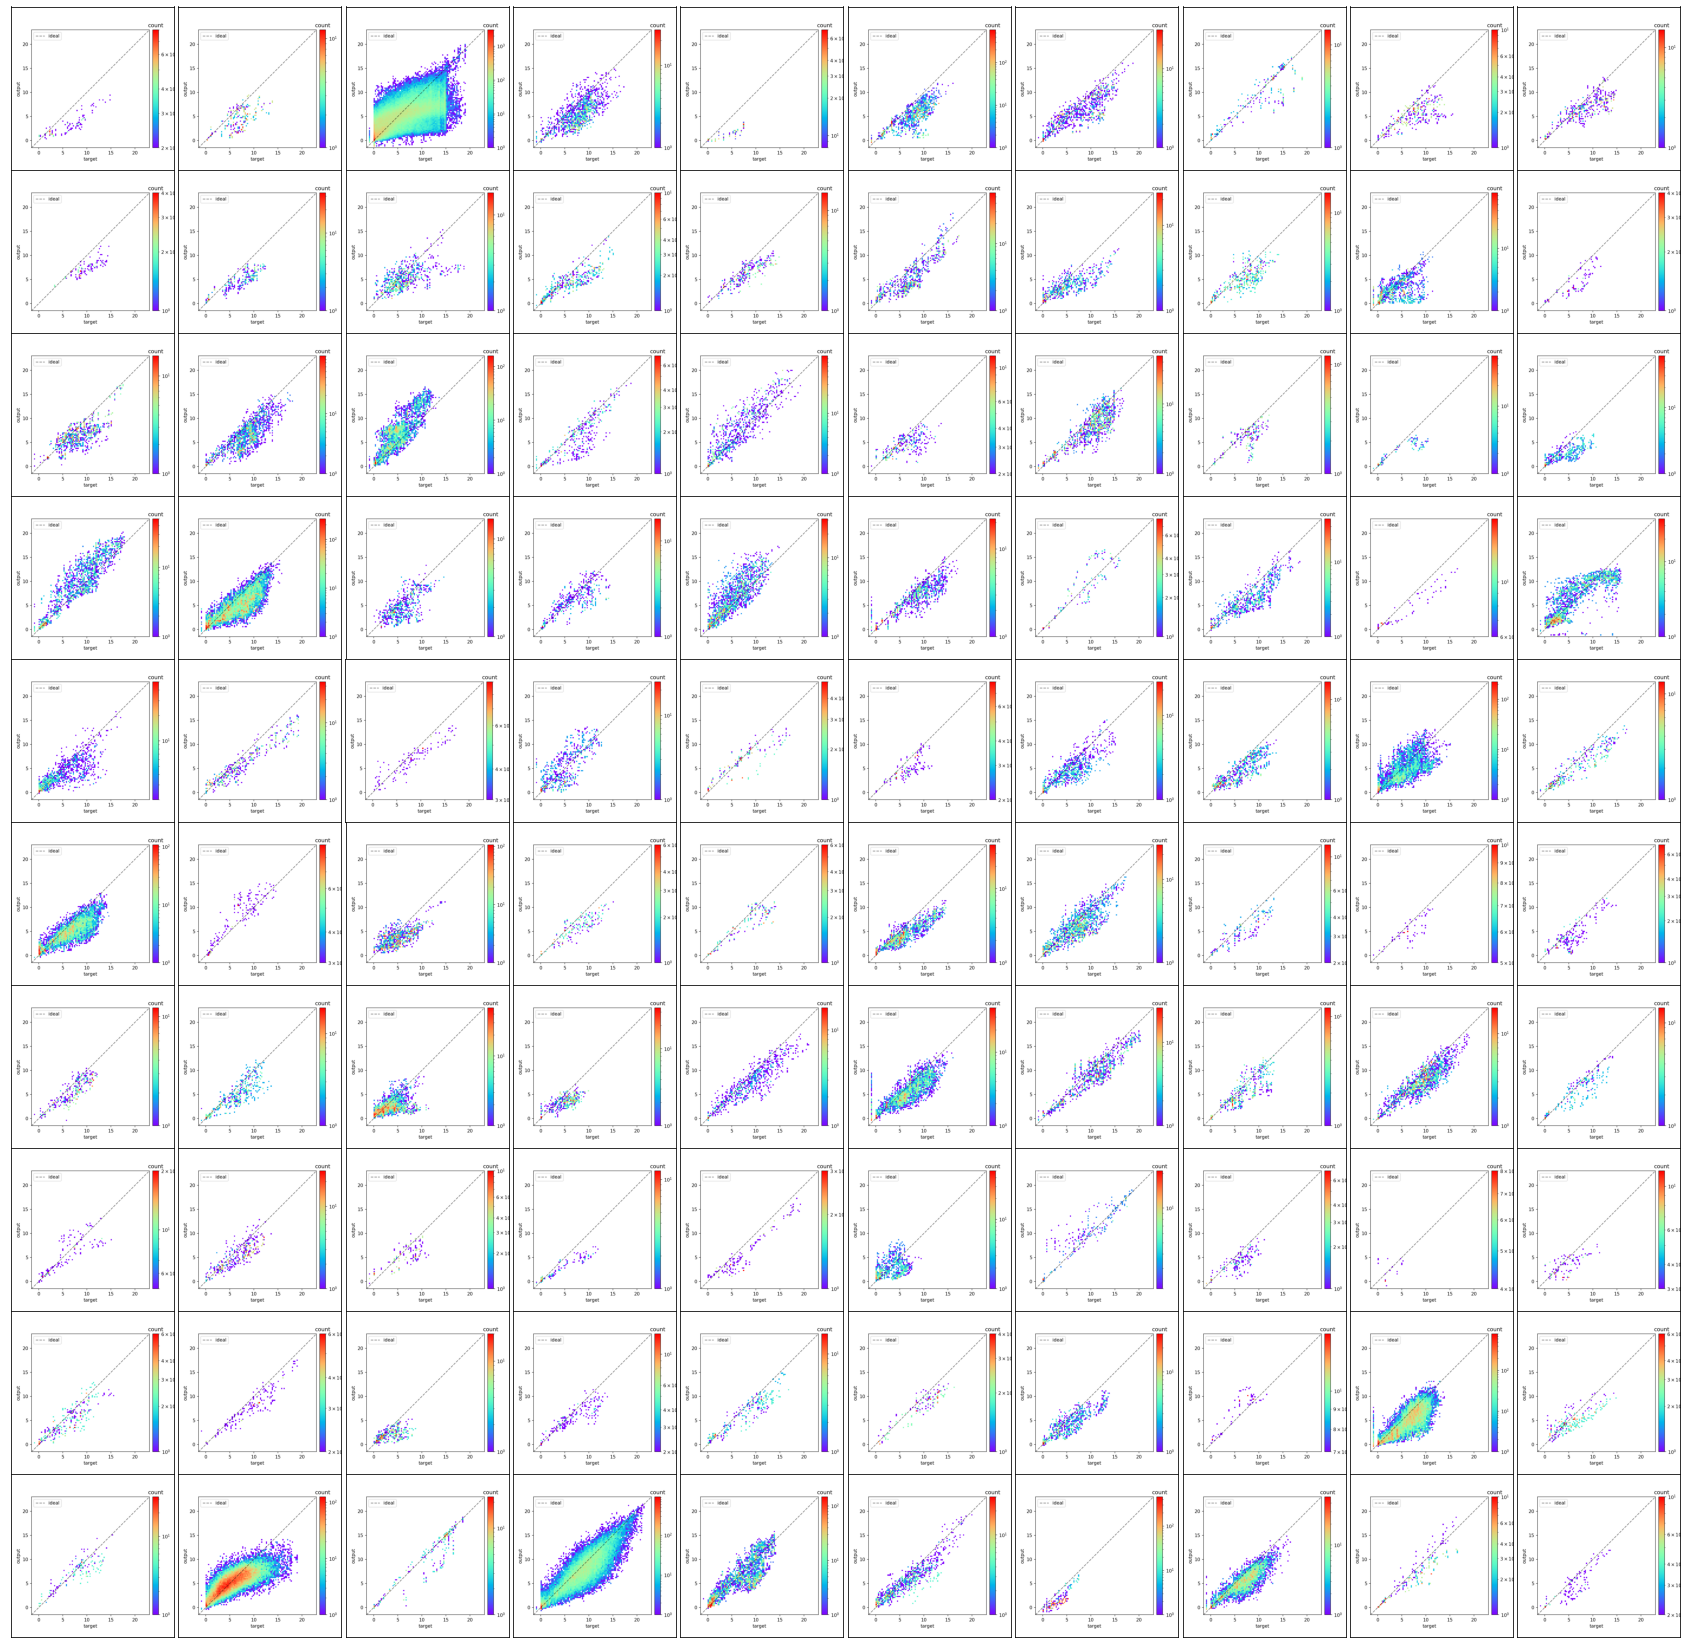

In [33]:
from PIL import Image
from matplotlib import pyplot as plt
pm = 3
# 空のリストを準備
d = []
for i in bad_figs:
    img = Image.open(i)
    img = np.asarray(img)
    d.append(img)
# タイル状に画像を一覧表示
fig, ax = plt.subplots(pm, pm, figsize=(30, 30))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(pm):
    for j in range(pm):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(d[pm*i+j], cmap="bone")
plt.show()

In [10]:
rands = [random.randint(1,len(rr)) for i in range(25)]
random_figs = [f'rf_fig/'+list(rr.keys())[i]+'.png' for i in rands]

In [19]:
import glob
seq_paths = []
for i in range(10,100):
    seq_paths.append(sorted(glob.glob(f'../../data/rbert/random/sequence/seq*{i}.fa')))


In [ ]:
max_length, batch_size = 440, 128
criterion = nn.MSELoss().to(device)
config = get_config(file_path = "../RNABERT/RNA_bert_config.json")
config.hidden_size = config.num_attention_heads * config.multiple    

seq_paths = sorted(glob.glob(f'../../data/Rfam/RF*.fa'))
acc_paths = sorted(glob.glob(f'../../data/Rfam/acc*.csv'))

JST = timezone(timedelta(hours=+9), 'JST')
dt_now = datetime.now(JST)
dt_now = dt_now.strftime('%Y%m%d-%H%M%S')
print(dt_now)
start = time.time()

target_all = []
output_all = []

print('repeat')
model = BertModel(config)
model = RBERT(model)
model = model_device(device, model)
model.load_state_dict(torch.load('path/repeat_RBERT.pth')['model_state_dict'])

for seq, acc in zip(seq_paths, acc_paths):
    print(seq, acc)
    dl, flag, division = make_dl([seq], [acc])

    if dl=="skip":
        print('skip')
        print(f'max:{flag}, len:{division}')
        continue

    data, target, output, loss, test_time = mode.test(device, model, dl, criterion)

    # 長い配列を復元するコード
    if flag:
        for i in range(division):
            if i==0:
                low_tar = target[i::division, :-55]
                low_out = output[i::division, :-55]
            elif i==division-1:
                target = np.concatenate([low_tar, target[i::division, 55:]], axis=1)
                output = np.concatenate([low_out, output[i::division, 55:]], axis=1)
            else:
                low_tar = np.concatenate([low_tar, target[i::division, 55:-55]], axis=1)
                low_out = np.concatenate([low_out, output[i::division, 55:-55]], axis=1)
                
    target_all.append(target)
    output_all.append(output)
    
finish = time.time()
print(f'全データ_makedl含む_{finish-start}秒')

target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

JST = timezone(timedelta(hours=+9), 'JST')
dt_now = datetime.now(JST)
dt_now = dt_now.strftime('%Y%m%d-%H%M%S')
print(dt_now)


20220720-144212
repeat
device:  cuda
../../data/Rfam/RF00001.fa ../../data/Rfam/acc00001.csv
Loss:0.4966 Timer:227.0874
../../data/Rfam/RF00002.fa ../../data/Rfam/acc00002.csv
Loss:0.5800 Timer:7.7204
../../data/Rfam/RF00003.fa ../../data/Rfam/acc00003.csv
Loss:0.7674 Timer:18.3512
../../data/Rfam/RF00004.fa ../../data/Rfam/acc00004.csv
Loss:1.2163 Timer:27.0354
../../data/Rfam/RF00005.fa ../../data/Rfam/acc00005.csv
Loss:0.5175 Timer:2257.5133
../../data/Rfam/RF00006.fa ../../data/Rfam/acc00006.csv
Loss:0.6912 Timer:1.6551
../../data/Rfam/RF00007.fa ../../data/Rfam/acc00007.csv
Loss:1.1435 Timer:1.4368
../../data/Rfam/RF00008.fa ../../data/Rfam/acc00008.csv
Loss:0.3411 Timer:1.3252
../../data/Rfam/RF00009.fa ../../data/Rfam/acc00009.csv
Loss:1.1023 Timer:8.9723
../../data/Rfam/RF00010.fa ../../data/Rfam/acc00010.csv
Loss:1.2107 Timer:40.9074
../../data/Rfam/RF00011.fa ../../data/Rfam/acc00011.csv
Loss:1.2260 Timer:1.8128
../../data/Rfam/RF00012.fa ../../data/Rfam/acc00012.csv
Loss:1.0

In [ ]:
max_length, batch_size = 440, 128
criterion = nn.MSELoss().to(device)
config = get_config(file_path = "../RNABERT/RNA_bert_config.json")
config.hidden_size = config.num_attention_heads * config.multiple    

seq_paths = sorted(glob.glob(f'../../data/GENCODE/human/seq*.fa'))
acc_paths = sorted(glob.glob(f'../../data/GENCODE/human/acc*.csv'))

JST = timezone(timedelta(hours=+9), 'JST')
dt_now = datetime.now(JST)
dt_now = dt_now.strftime('%Y%m%d-%H%M%S')
print(dt_now)
start = time.time()

target_all = []
output_all = []

print('repeat')
model = BertModel(config)
model = RBERT(model)
model = model_device(device, model)
model.load_state_dict(torch.load('path/repeat_RBERT.pth')['model_state_dict'])

for seq, acc in zip(seq_paths, acc_paths):
    print(seq, acc)
    dl, flag, division = make_dl([seq], [acc])

    if dl=="skip":
        print('skip')
        print(f'max:{flag}, len:{division}')
        continue

    data, target, output, loss, test_time = mode.test(device, model, dl, criterion)

    # 長い配列を復元するコード
    if flag:
        for i in range(division):
            if i==0:
                low_tar = target[i::division, :-55]
                low_out = output[i::division, :-55]
            elif i==division-1:
                target = np.concatenate([low_tar, target[i::division, 55:]], axis=1)
                output = np.concatenate([low_out, output[i::division, 55:]], axis=1)
            else:
                low_tar = np.concatenate([low_tar, target[i::division, 55:-55]], axis=1)
                low_out = np.concatenate([low_out, output[i::division, 55:-55]], axis=1)
                
    target_all.append(target)
    output_all.append(output)
    
finish = time.time()
print(f'全データ_makedl含む_{finish-start}秒')

target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

JST = timezone(timedelta(hours=+9), 'JST')
dt_now = datetime.now(JST)
dt_now = dt_now.strftime('%Y%m%d-%H%M%S')
print(dt_now)

#     print('stem')
#     model = BertModel(config)
#     model = RBERT(model)
#     model = model_device(device, model)
#     model.load_state_dict(torch.load('path/stem_RBERT.pth')['model_state_dict'])
#     data, target, output, loss, test_time = mode.test(device, model, dl, criterion)

#     if dl=="skip":
#         print('skip')
#         print(f'max:{flag}, len:{division}')

#     data, target, output, loss, test_time = mode.test(device, model, dl, criterion)

#     # 長い配列を復元するコード
#     if flag:
#         start = time.time()
#         for i in range(division):
#             if i==0:
#                 low_tar = target[i::division, :-55]
#                 low_out = output[i::division, :-55]
#             elif i==division-1:
#                 target = np.concatenate([low_tar, target[i::division, 55:]], axis=1)
#                 output = np.concatenate([low_out, output[i::division, 55:]], axis=1)
#             else:
#                 low_tar = np.concatenate([low_tar, target[i::division, 55:-55]], axis=1)
#                 low_out = np.concatenate([low_out, output[i::division, 55:-55]], axis=1)
#         finish = time.time()
#         print(f'concat: {finish-start}秒')

    # target_rem, output_rem = result.remove_padding(target, output)
    # print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
    # result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

NBERT
random_repeat
device:  cuda
Loss:0.8588 Timer:35.9055
True Loss: 1.2425402402877808


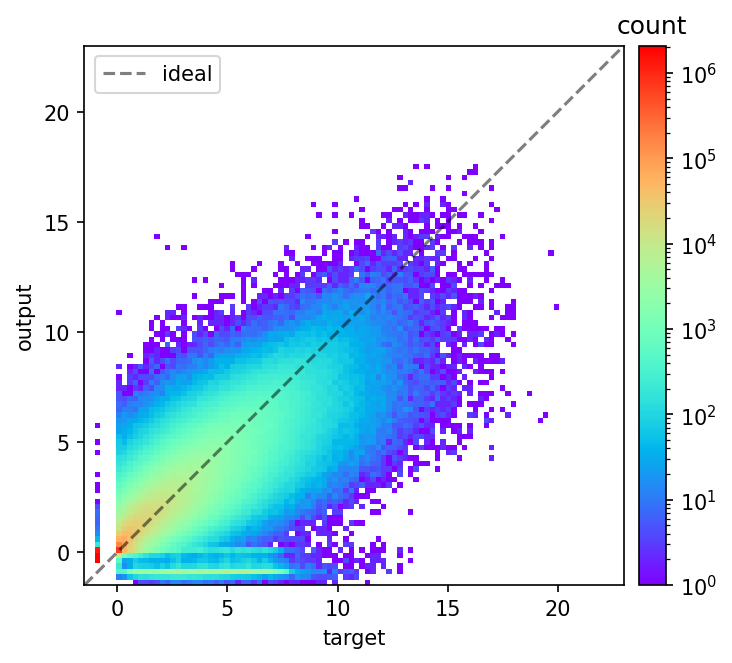

random_stem
device:  cuda
Loss:1.8744 Timer:35.7538
True Loss: 2.623690128326416


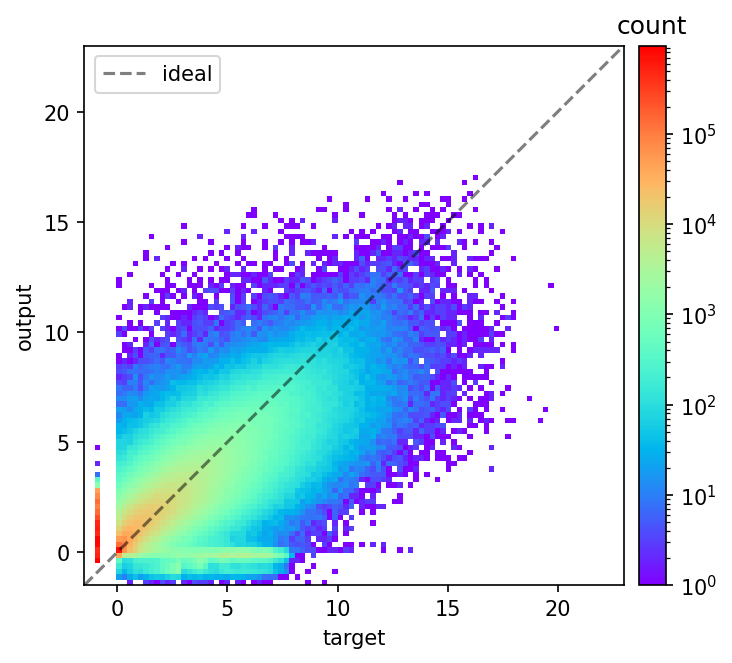

CNN
random_repeat
device:  cuda
Loss:0.5572 Timer:11.7255
True Loss: 1.7725565433502197


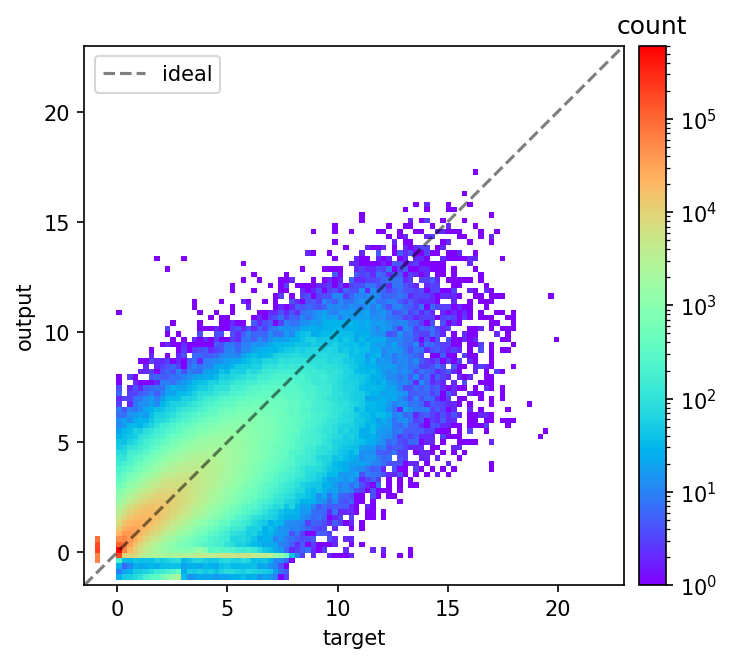

random_stem
device:  cuda
Loss:0.6035 Timer:11.8077
True Loss: 1.8652961254119873


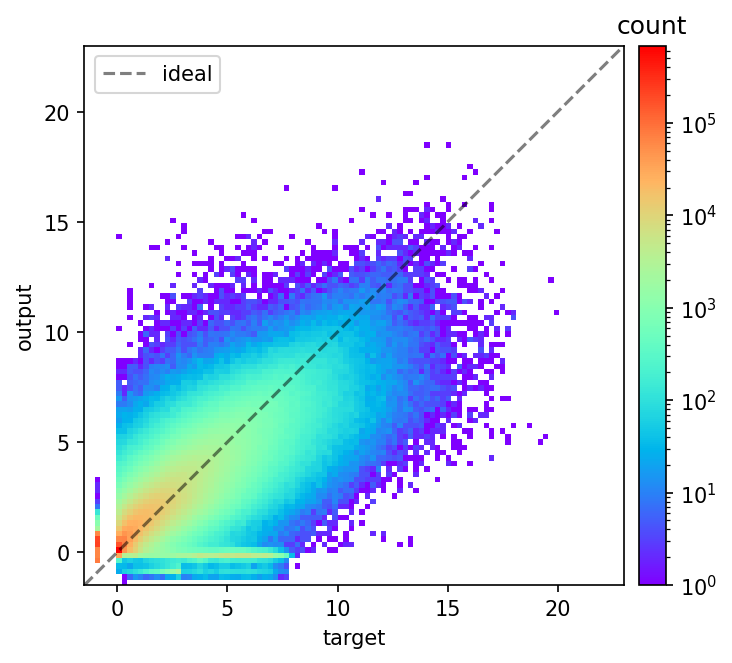

DCNN
random_repeat
device:  cuda
Loss:0.4891 Timer:42.6058
True Loss: 1.8112494945526123


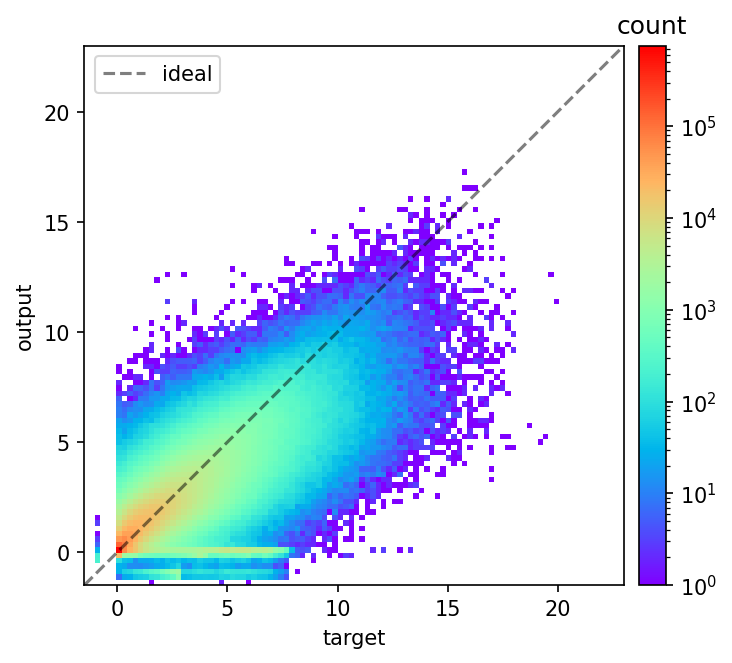

random_stem
device:  cuda
Loss:0.5082 Timer:42.3498
True Loss: 1.8791147470474243


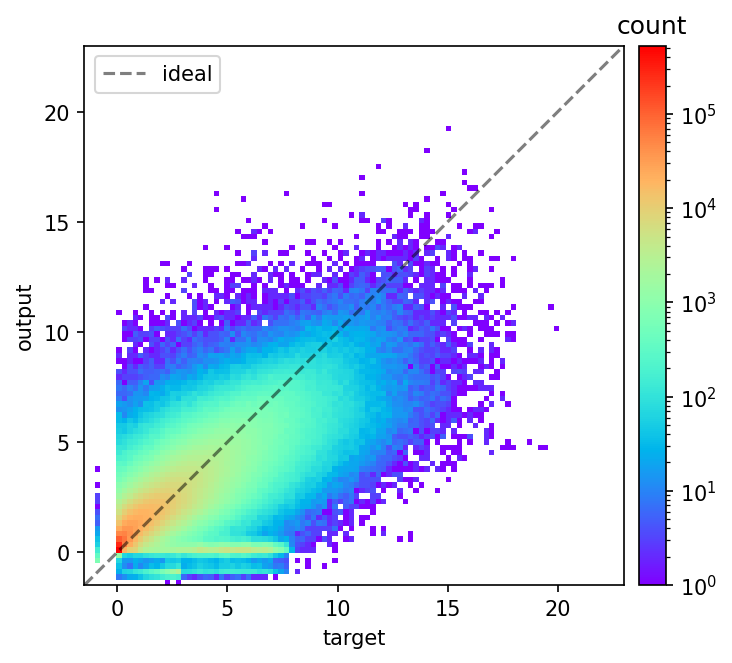

In [15]:
max_length, batch_size = 440, 128
criterion = nn.MSELoss().to(device)
config = get_config(file_path = "../RNABERT/RNA_bert_config.json")
config.hidden_size = config.num_attention_heads * config.multiple    

val_seq_path = [f'../../data/rbert/random/sequence/seq999.fa']
val_acc_path = [f'../../data/rbert/random/accessibility/acc999.csv']
dl, flag, division = make_dl(val_seq_path, val_acc_path)

print('NBERT')
print('random_repeat')
model = BertModel(config)
model = NBERT(model)
model = model_device(device, model)
model.load_state_dict(torch.load('path/repeat_NBERT.pth')['model_state_dict'])
max_length, batch_size = 440, 128
data, target, output, loss, test_time = mode.test(device, model, dl, criterion)
target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

print('random_stem')
model = BertModel(config)
model = NBERT(model)
model = model_device(device, model)
model.load_state_dict(torch.load('path/stem_NBERT.pth')['model_state_dict'])
max_length, batch_size = 440, 128
data, target, output, loss, test_time = mode.test(device, model, dl, criterion)
target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')
      
del model
print('CNN')
print('random_repeat')
model = CNN()
model = model_device(device, model)
model.load_state_dict(torch.load('path/repeat_CNN.pth')['model_state_dict'])
max_length, batch_size = 440, 128
data, target, output, loss, test_time = mode.test(device, model, dl, criterion)
target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

print('random_stem')
model = CNN()
model = model_device(device, model)
model.load_state_dict(torch.load('path/stem_CNN.pth')['model_state_dict'])
max_length, batch_size = 440, 128
data, target, output, loss, test_time = mode.test(device, model, dl, criterion)
target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

print('DCNN')
print('random_repeat')
model = DCNN()
model = model_device(device, model)
model.load_state_dict(torch.load('path/repeat_DCNN.pth')['model_state_dict'])
max_length, batch_size = 440, 128
data, target, output, loss, test_time = mode.test(device, model, dl, criterion)
target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

print('random_stem')
model = DCNN()
model = model_device(device, model)
model.load_state_dict(torch.load('path/stem_DCNN.pth')['model_state_dict'])
max_length, batch_size = 440, 128
data, target, output, loss, test_time = mode.test(device, model, dl, criterion)
target_rem, output_rem = result.remove_padding(target, output)
print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

In [38]:
# long_fasta,long_accの中身を個別に解析しましょう
for f, c in zip(long_fasta, long_acc):
    # make_dlはリストで渡すようにしてるけどリスト内全部に対して最大長でpaddingするので要素1つのリストを渡す
    print(f[-8:-3])
    dl, flag, division = make_dl([f], [c])

    if dl=="skip":
        print('skip')
        print(f'max:{flag}, len:{division}')
        continue

    data, target, output, loss, test_time = mode.test(device, model, dl, criterion)

        # 長い配列を復元するコード
    if flag:
        start = time.time()
        for i in range(division):
            if i==0:
                low_tar = target[i::division, :-55]
                low_out = output[i::division, :-55]
            elif i==division-1:
                target = np.concatenate([low_tar, target[i::division, 55:]], axis=1)
                output = np.concatenate([low_out, output[i::division, 55:]], axis=1)
            else:
                low_tar = np.concatenate([low_tar, target[i::division, 55:-55]], axis=1)
                low_out = np.concatenate([low_out, output[i::division, 55:-55]], axis=1)
        finish = time.time()
        print(f'concat: {finish-start}')



    # target_rem, output_rem = result.remove_padding(target, output)
    # print(f'True Loss: {((np.array(target_rem) - np.array(output_rem))**2).mean(axis=0)}')
    # result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

/seq1
max: 16357, len: 1000
seq_split: 0.0002560615539550781
acc_split: 47.46254277229309
Loss:0.2204 Timer:53.1229
concat: 0.7133152484893799


In [39]:
argmin = np.argmin(np.count_nonzero(target==-1, axis=1))

In [42]:
result.pickup_cor(target, output, threshold=0.85)
result.pickup_sum(target, output, threshold=5, amount=50)
result.pickup_abs(target, output, threshold=7.5)

0.8252912427654056
0.8301236500653691
[936, 937]
[936]
7.733295
7.59888
7.957512
7.598859
7.957652
7.5316186
7.5316186
7.583918
7.5152035
7.8107915
7.764785
7.9763737
7.582638
7.885215
7.8756485
7.7362947
7.7362947
7.5983863
7.8517013
8.327766
8.433729
8.047506
8.047376
8.047506
8.047496
8.047496
8.047476
8.047506
8.047506
8.047506
8.047506
8.047506
8.26645
8.26645
8.26645
8.047506
8.047506
8.758991
8.348795
7.5913696
7.619136
[[28, 2359], [83, 383], [85, 459], [87, 383], [88, 459], [112, 1000], [113, 1000], [114, 1000], [177, 745], [197, 840], [199, 876], [275, 379], [651, 753], [674, 2006], [765, 174], [819, 2051], [820, 2051], [821, 2043], [822, 2041], [876, 2247], [877, 2238], [878, 2233], [880, 2233], [885, 2233], [886, 2233], [887, 2233], [889, 2233], [890, 2233], [891, 2233], [893, 2233], [896, 2233], [897, 2233], [898, 2241], [899, 2241], [900, 2241], [903, 2233], [905, 2233], [906, 2236], [907, 2233], [929, 1961], [931, 1969]]


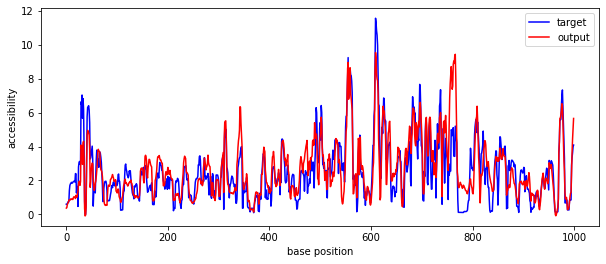

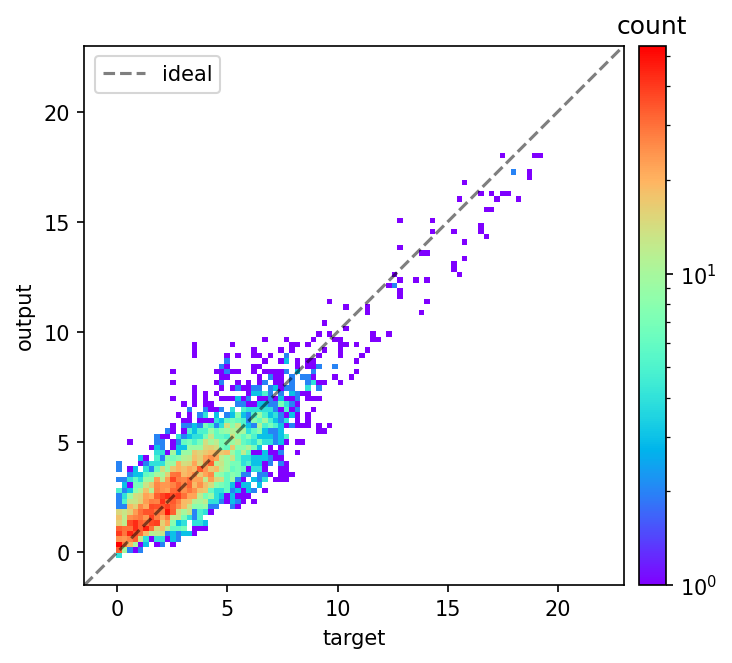

In [54]:
result.one_plot(target[argmin], output[argmin], length=1000)
target_rem, output_rem = result.remove_padding(target[argmin], output[argmin])
result.plot_result(target_rem, output_rem, lims=[-1.5, 23], mode='show')

In [99]:
result.cal_indicators(np.array([target_rem]), np.array([output_rem]))

([0.8655826996978413], [1.8073325])

In [ ]:
class fourPowerLoss(nn.Module):
    def __init__(self):
        super(fourPowerLoss, self).__init__()

    def forward(self, input, target):
        return torch.square(F.mse_loss(input, target))